## Notebook for the generation of a batch-corrected manifold for Mixed cell states using `scVI` prior to `cellrank`

- **Developed by**: Carlos Talavera-López Ph.D
- **Institute of Computational Biology - Computational Health Centre - Helmholtz Munich**
- v230504

### Load required modules

In [1]:
import sys
import scvi
import torch
import anndata
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import numpy as np
import scipy as sp
import pandas as pd
import scanpy as sc
import numpy.random as random
from scib_metrics.benchmark import Benchmarker

from umap import UMAP
import warnings; warnings.simplefilter('ignore')

Global seed set to 0
/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [2]:
save_path = "../data/"

In [3]:
%matplotlib inline
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [4]:
torch.cuda.is_available()

False

In [5]:
torch.set_float32_matmul_precision('medium')

In [6]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                 9.4.0
absl                NA
appnope             0.1.3
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
brotli              NA
certifi             2022.12.07
cffi                1.15.1
charset_normalizer  2.1.1
chex                0.1.6
colorama            0.4.6
contextlib2         NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.6
decorator           5.1.1
docrep              0.3.2
executing           1.2.0
flax                0.5.0
fsspec              2023.3.0
h5py                3.8.0
hypergeom_ufunc     NA
idna                3.4
igraph              0.10.4
importlib_resources NA
invgauss_ufunc      NA
ipykernel           6.15.0
ipywidgets          8.0.6
jax                 0.4.6
jaxlib              0.4.6
jedi                0.18.2
joblib              1.2.0
kiwisolver          1.4.4
leidenalg           0.9.1
lightning

In [7]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis = 0).astype(int), adata.X.sum(axis = 0))

### Read in datasets

- Read in formatted object

In [8]:
adata_all = sc.read_h5ad('../../data/Marburg_All_ctl230404_leiden_states.raw.h5ad')
adata_all

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', 'n_cells_by_counts-V5', 'mean_counts-V5', 'pct_dropout_by_coun

### Subset Mixedl cells 

In [9]:
adata_all.obs['leiden_states'].cat.categories

Index(['Goblet_0', 'Club_1', 'SupraB_2', 'Basal_3', 'SupraB_4', 'SupraB_5',
       'Goblet_6', 'Goblet_7', 'Basal_8', 'Club_9', 'MultiC_10', 'Mixed_11',
       'Mixed_12', 'Mixed_13', 'SupraB_14', 'SupraB_15', 'Mixed_16',
       'Mixed_17', 'Club_18'],
      dtype='object')

In [10]:
adata_mixed = adata_all[adata_all.obs['leiden_states'].isin(['Mixed_11',
       'Mixed_12', 'Mixed_13', 'Mixed_16', 'Mixed_17'])]
adata_mixed

View of AnnData object with n_obs × n_vars = 12256 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', 'n_cells_by_counts-V5', 'mean_counts-V5', 'pct_dropout

In [11]:
adata = adata_mixed[adata_mixed.obs['group'].isin(['healthy_ctrl'])]
adata

View of AnnData object with n_obs × n_vars = 717 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', 'n_cells_by_counts-V5', 'mean_counts-V5', 'pct_dropout_b

In [12]:
X_is_raw(adata)

True

In [13]:
adata.obs['batch'].value_counts()

GER14_CRTL       181
GnR08_CTRL       181
GER02_CTRL       106
ST07_CSE_CTRL     97
GER12_CTRL        94
CSE_06_CRTL       58
Name: batch, dtype: int64

### Calculate HVGs

In [14]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

In [15]:
sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "batch",
    subset = True
)
adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 717 × 7000
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', 'n_cells_by_counts-V5', 'mean_counts-V5', 'pct_dropout_by_counts-

### Data integration with `scVI`

In [16]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer = "counts",
    labels_key = "leiden_states",
    categorical_covariate_keys = ["batch", "donor"],
    continuous_covariate_keys = ["n_genes", "n_counts"]
)

In [17]:
model = scvi.model.SCVI(adata, n_layers = 3, n_latent = 50, gene_likelihood = "nb", dispersion = 'gene-batch')
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 50, n_layers: 3, dropout_rate: 0.1, dispersion: gene-batch, gene_likelihood: nb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [18]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [02:50<00:00,  2.37it/s, loss=6.93e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:50<00:00,  2.34it/s, loss=6.93e+03, v_num=1]


In [19]:
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


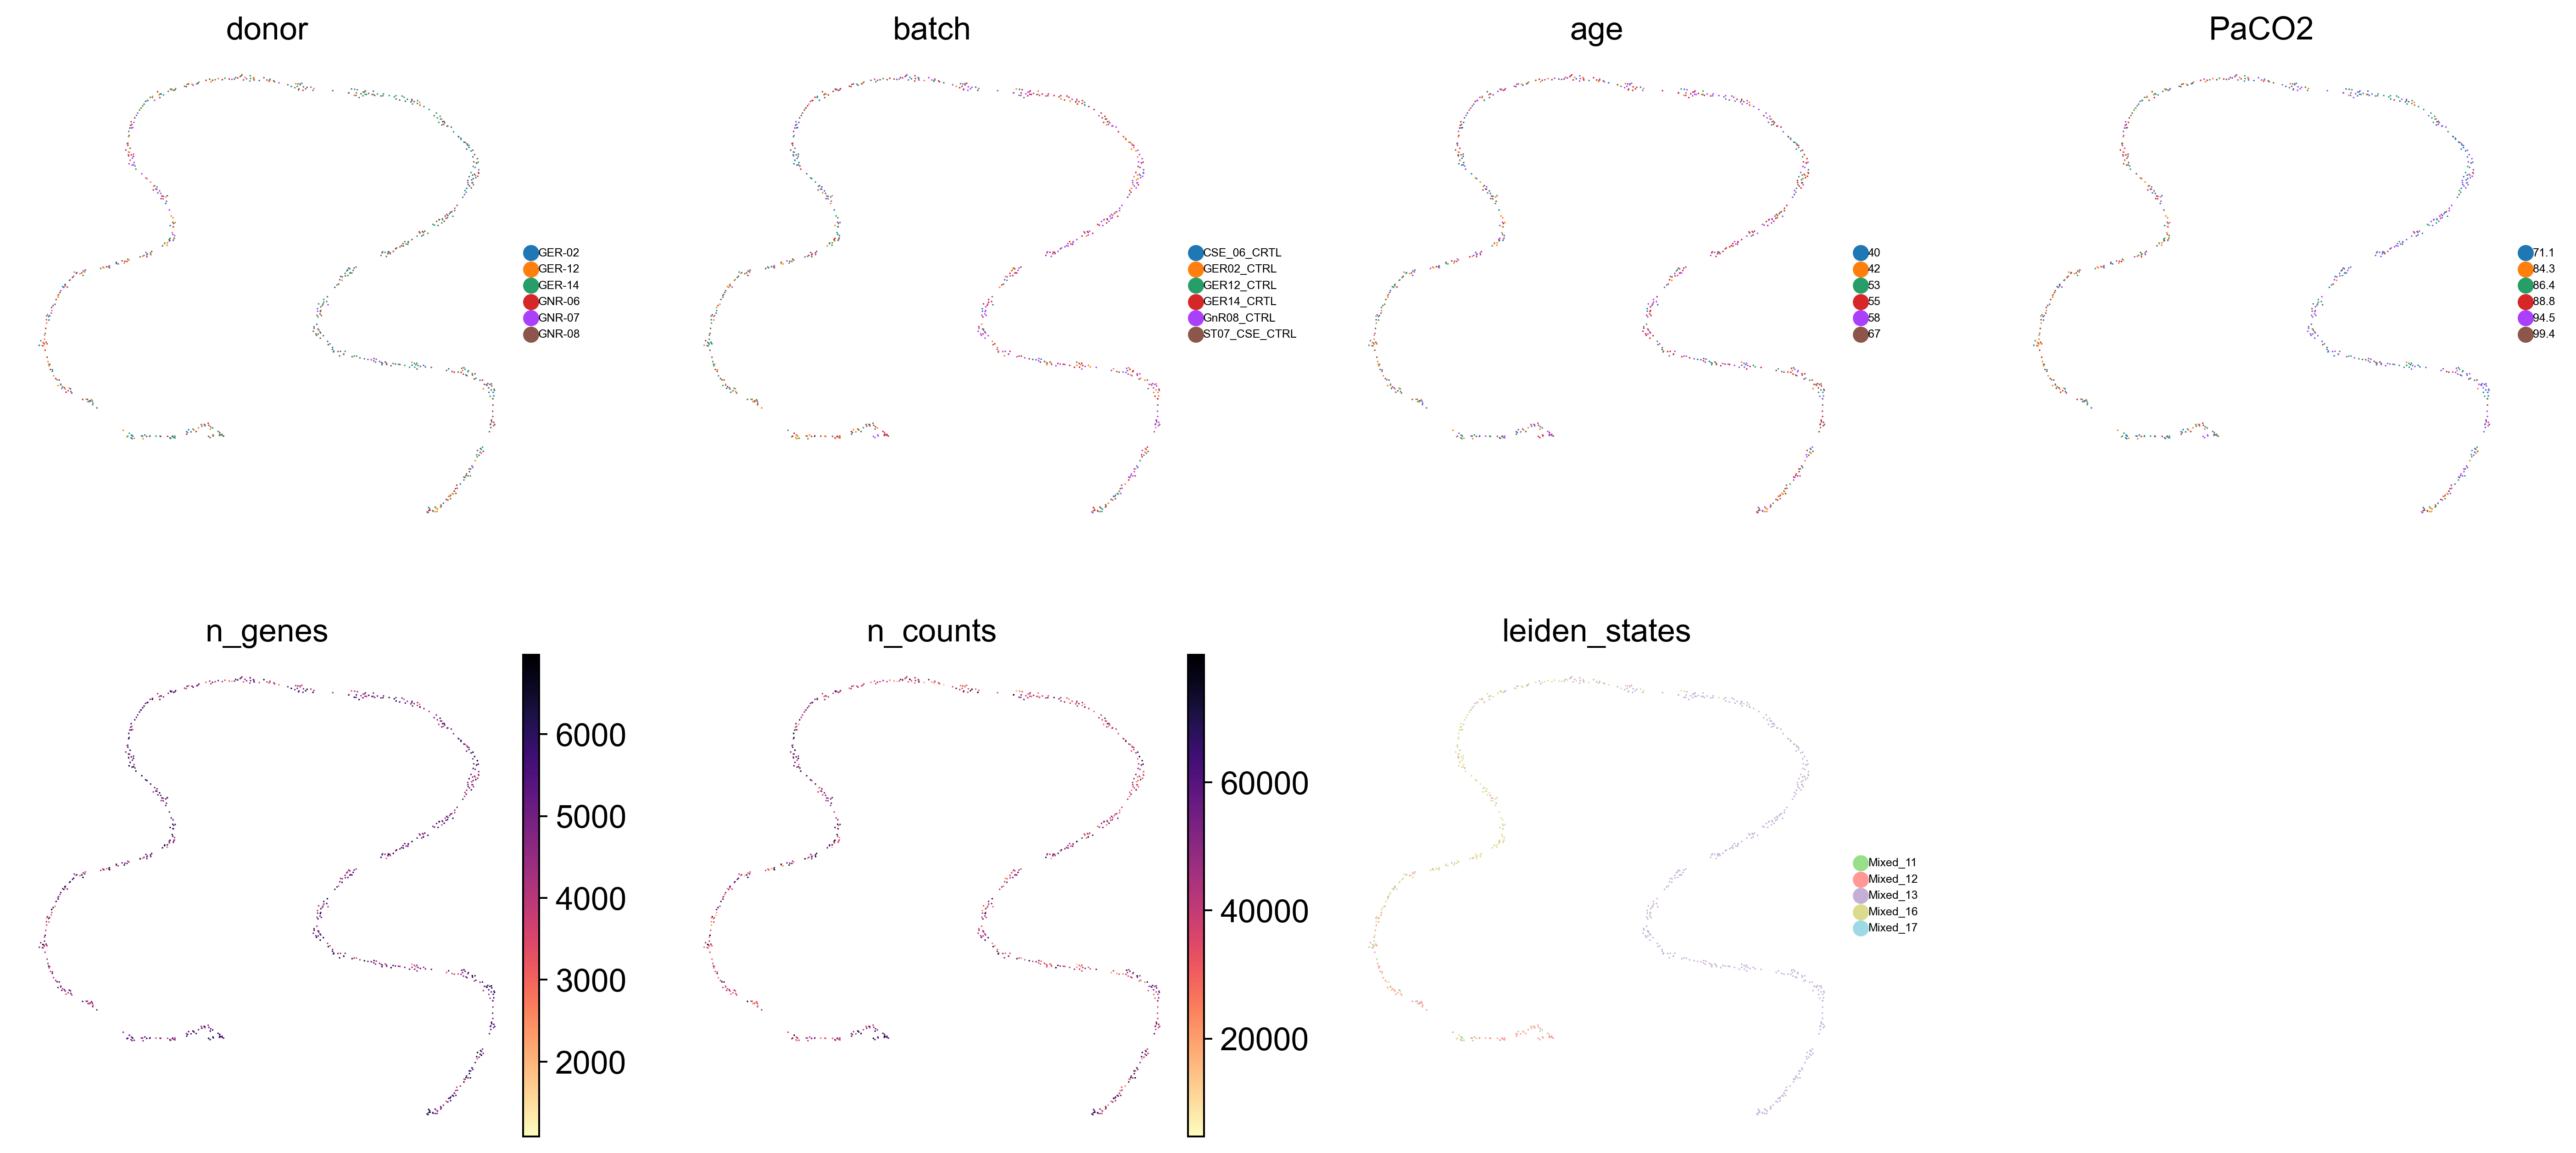

In [20]:
sc.pp.neighbors(adata, use_rep = "X_scVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['donor', 'batch','age', 'PaCO2', 'n_genes', 'n_counts', 'leiden_states'], size = 2, legend_fontsize = 5, ncols = 4)

### Score IAV genes across manifold

In [21]:
adata_log = adata.copy()

sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)
adata_log.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(adata_log, inplace = False)["X"]
)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['ACTB', 'BPIFA1', 'KRT5', 'LAMC2', 'LCN2', 'MT2A', 'NC_026431.1', 'NC_026432.1', 'NC_026433.1', 'NC_026434.1', 'NC_026435.1', 'NC_026436.1', 'NC_026437.1', 'S100A2', 'SCGB1A1', 'SCGB3A1', 'SERPINE1', 'SLPI', 'WFDC2']
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


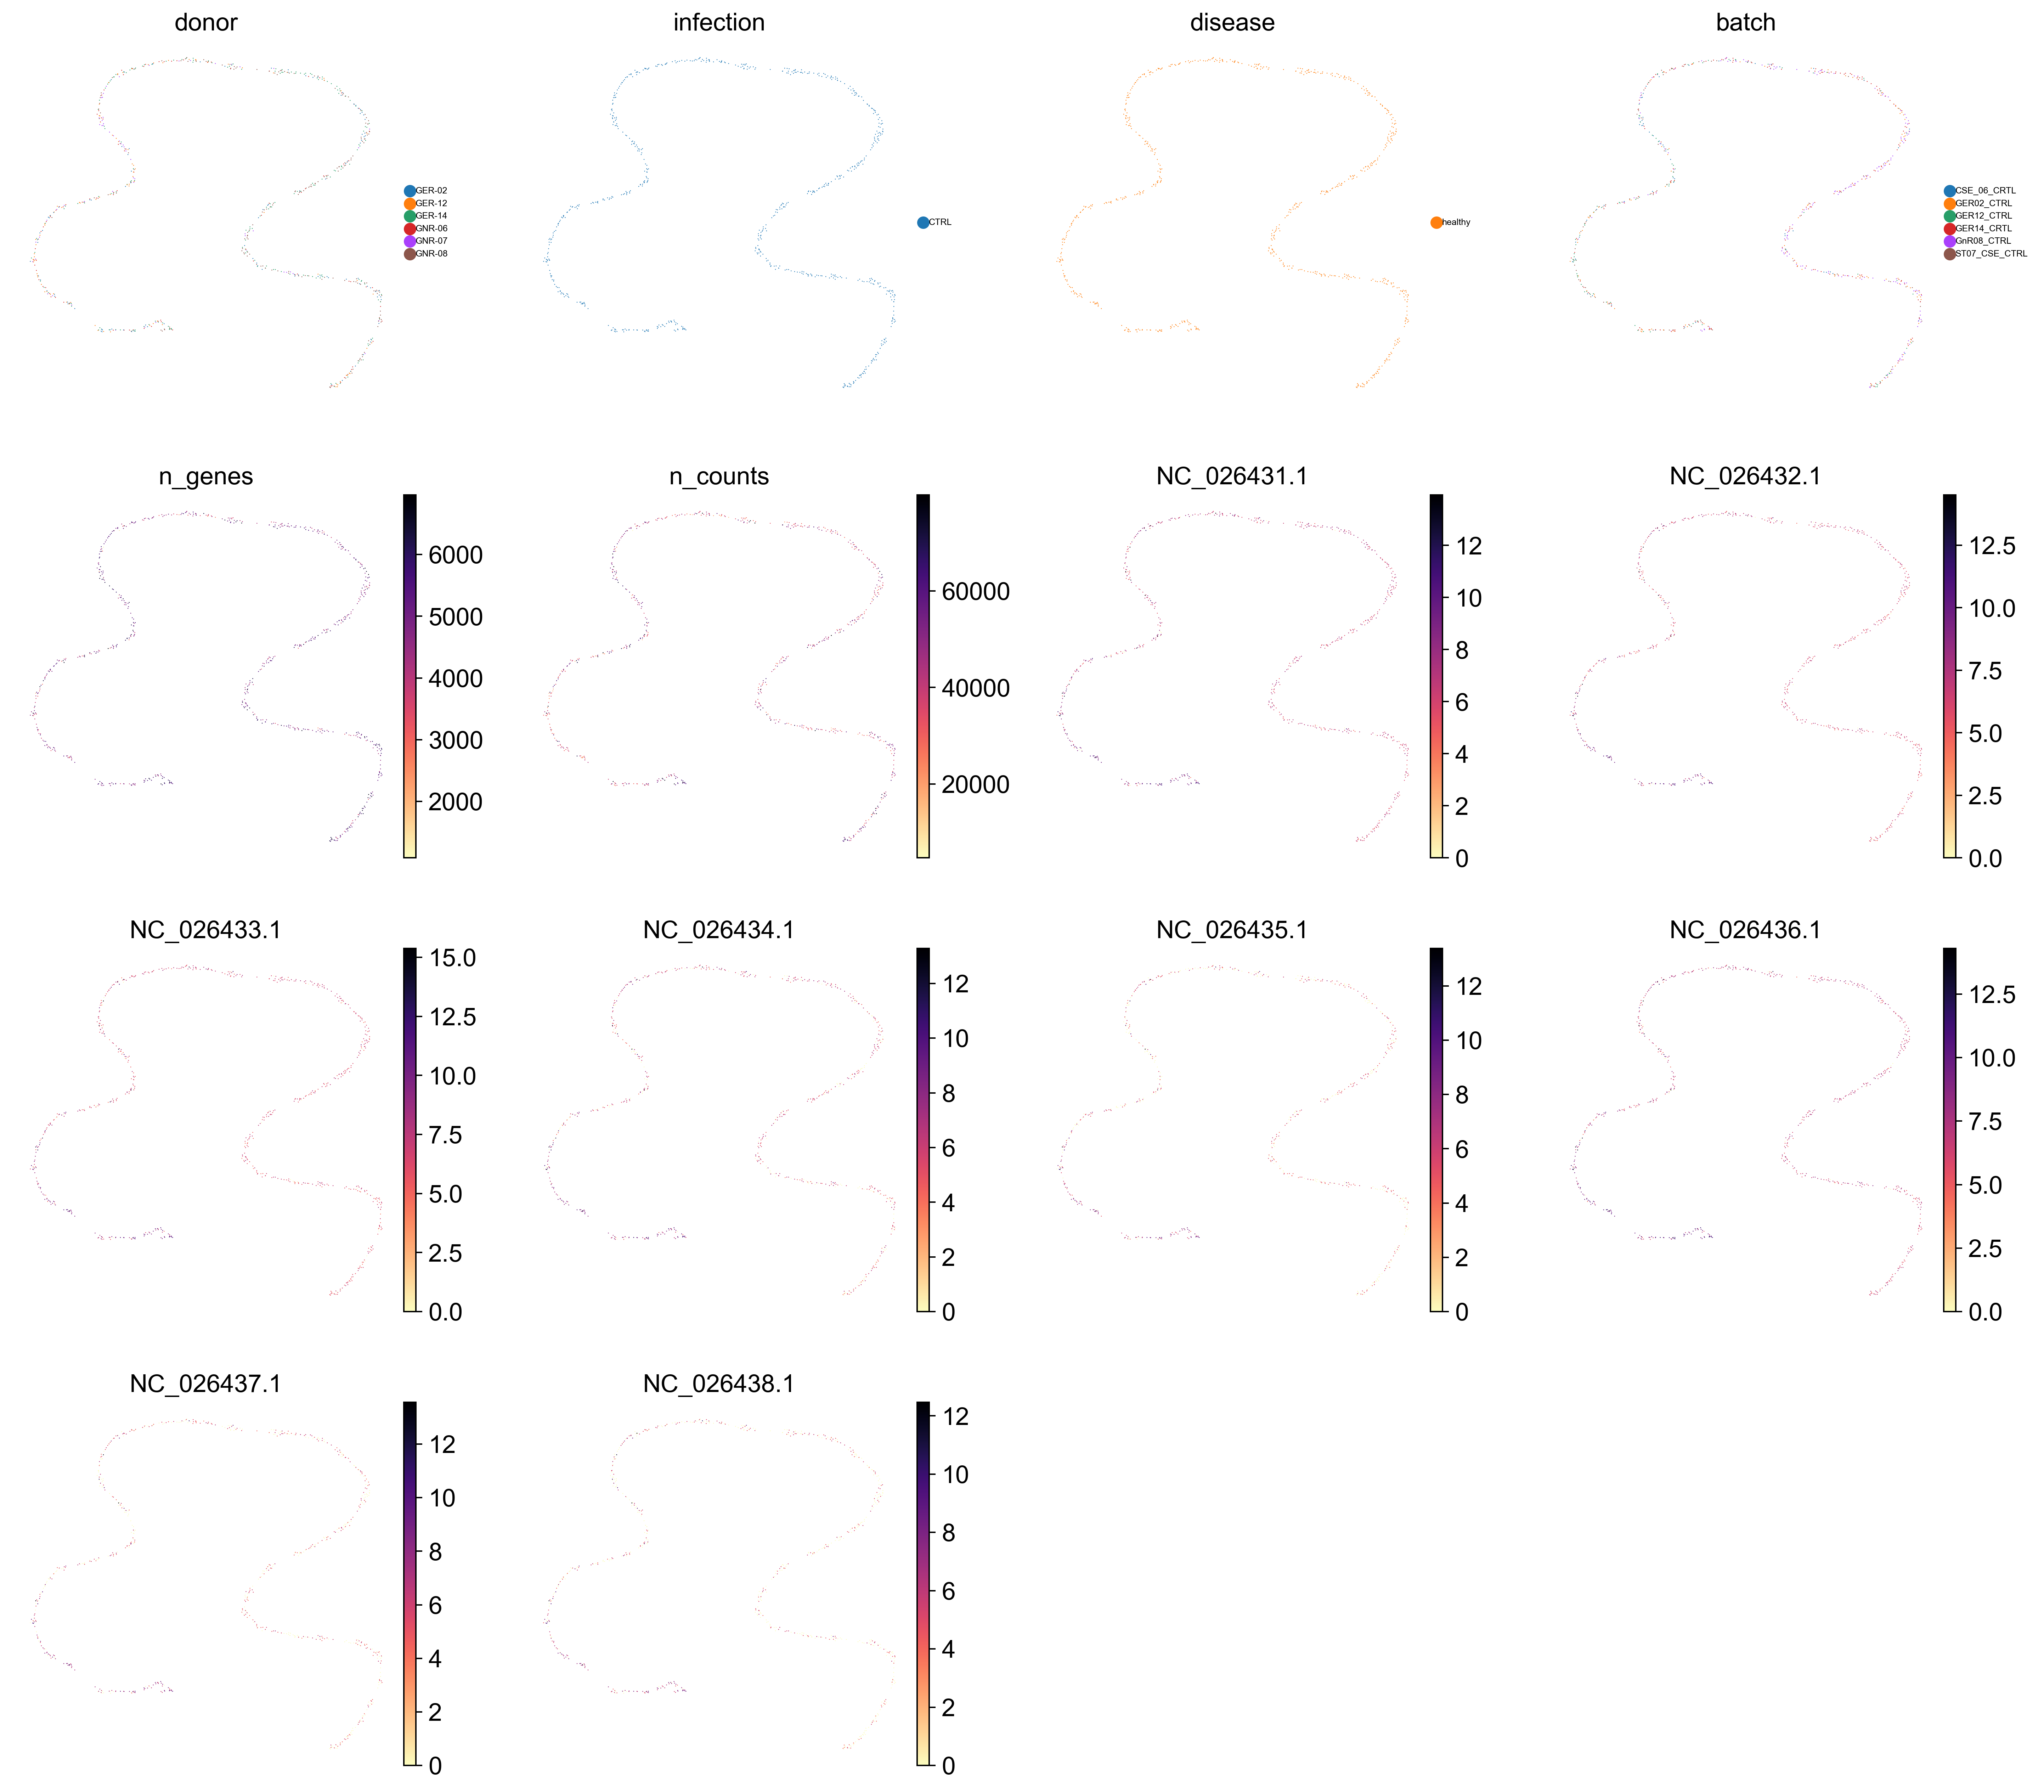

In [22]:
sc.pl.umap(adata_log, frameon = False, color = ['donor', 'infection', 'disease', 'batch', 'n_genes', 'n_counts', 'NC_026431.1','NC_026432.1','NC_026433.1','NC_026434.1','NC_026435.1','NC_026436.1','NC_026437.1','NC_026438.1'], size = 1, legend_fontsize = 5, ncols = 4)

computing score 'IAV_score'
    finished: added
    'IAV_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)


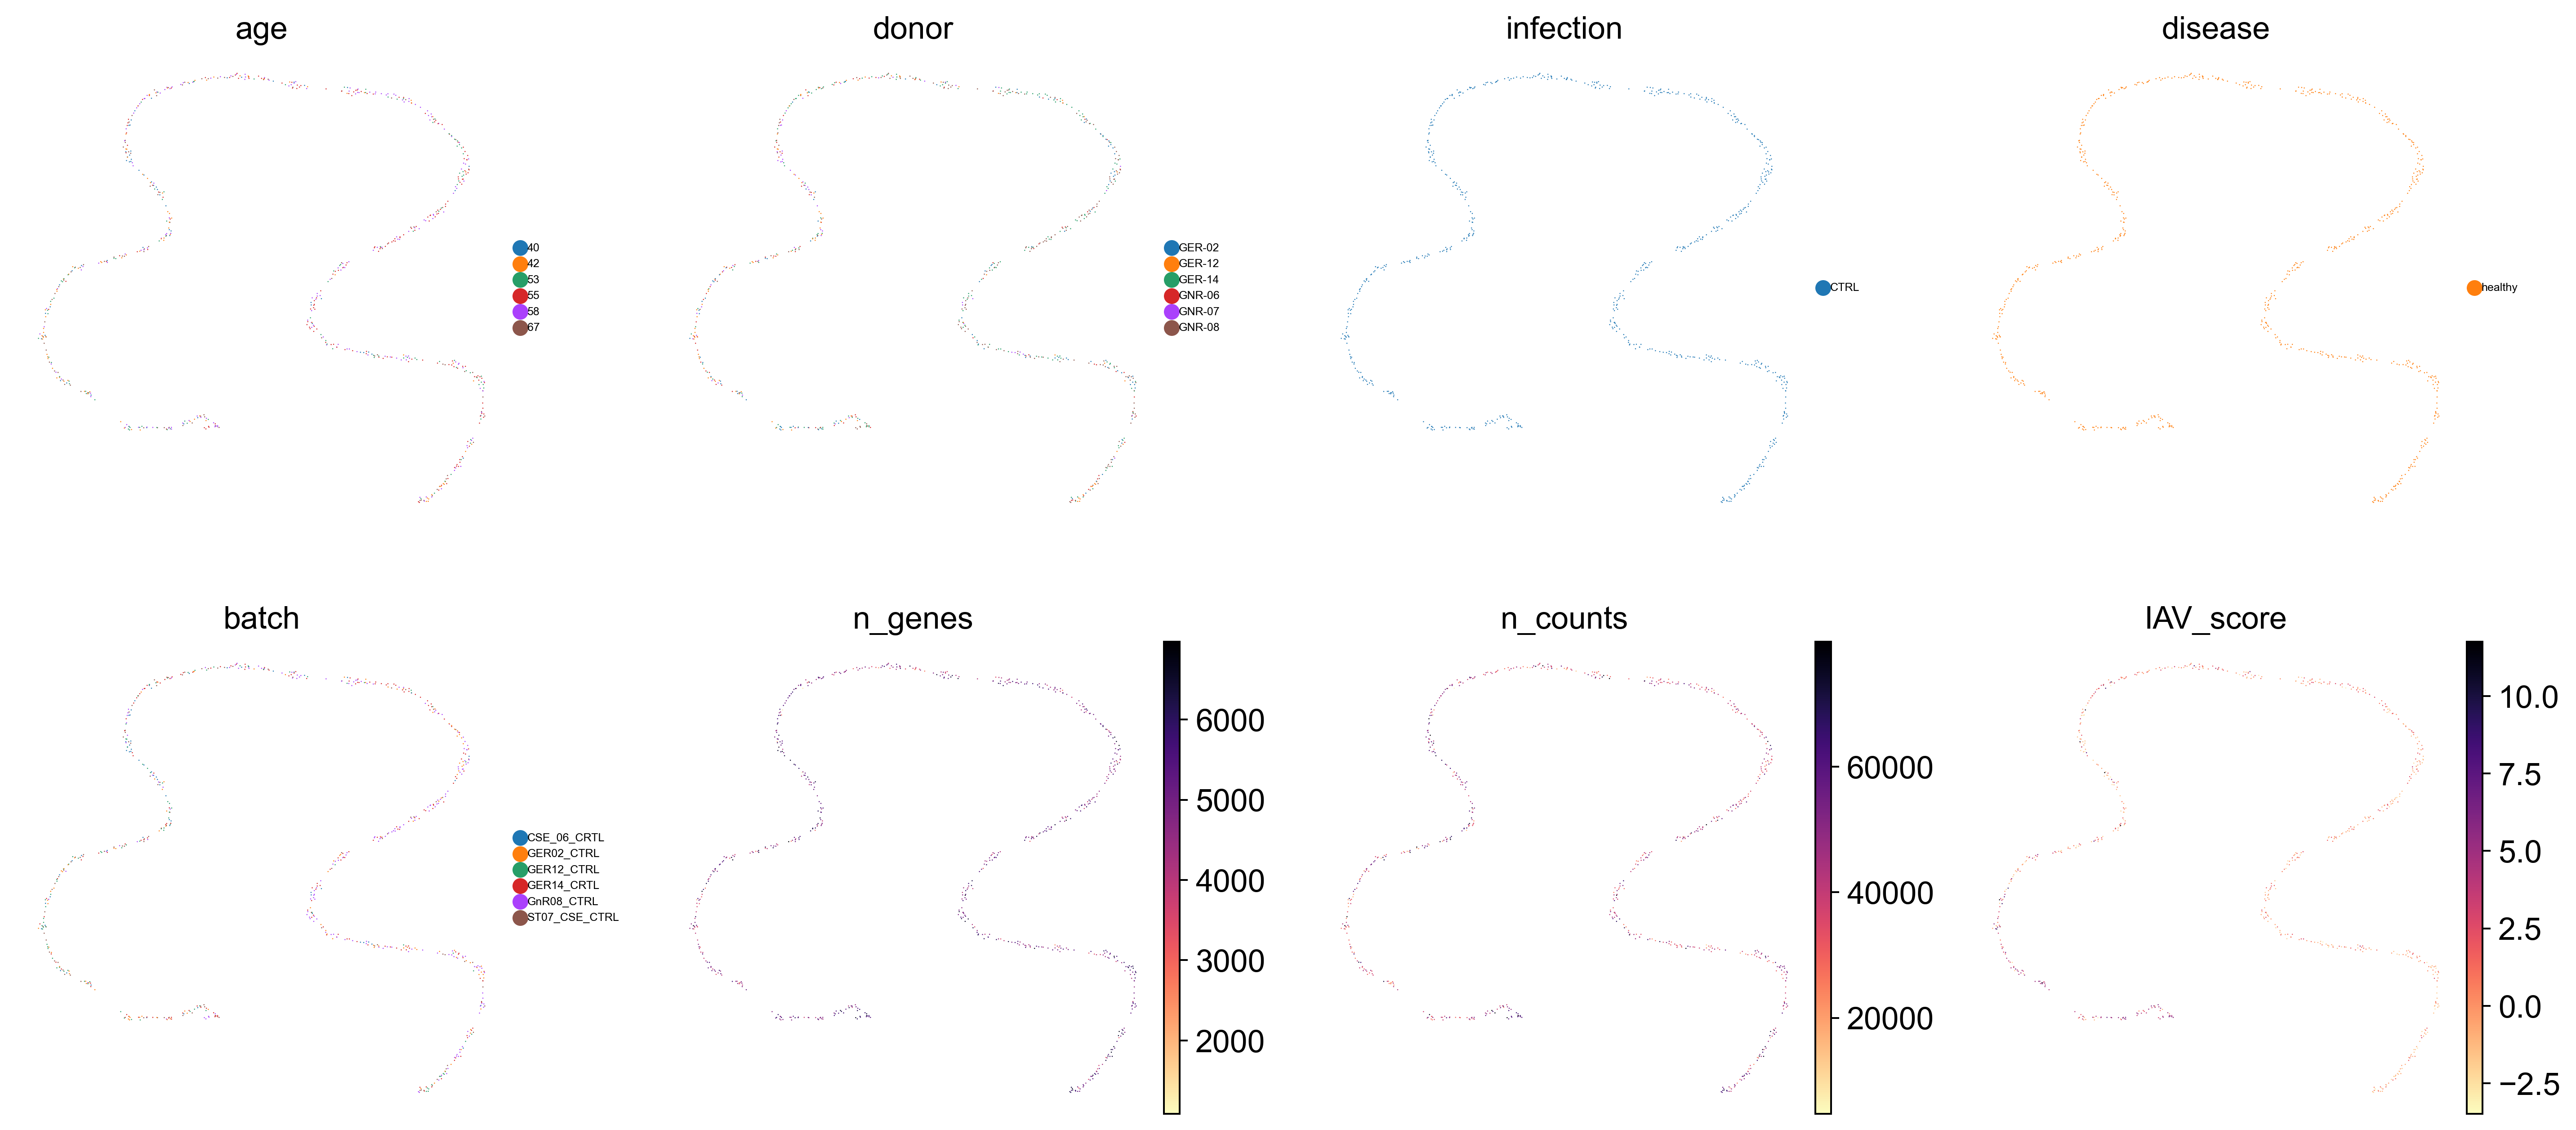

In [23]:
iav_genes = ['NC_026431.1','NC_026432.1','NC_026433.1','NC_026434.1','NC_026435.1','NC_026436.1','NC_026437.1','NC_026438.1']
sc.tl.score_genes(adata_log, iav_genes, score_name = 'IAV_score', random_state = 1712)
sc.pl.umap(adata_log, frameon = False, color = ['age', 'donor', 'infection', 'disease', 'batch', 'n_genes', 'n_counts', 'IAV_score'], size = 1, legend_fontsize = 5, ncols = 4)

In [24]:
adata.obs['IAV_score'] = adata_log.obs['IAV_score'].copy()

In [25]:
adata

AnnData object with n_obs × n_vars = 717 × 7000
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', 'n_cells_by_counts-V5', 'mean_counts-V5', 'pct_dropout_by_counts-

In [26]:
X_is_raw(adata)

True

In [27]:
adata.X = sp.sparse.csc_matrix(adata.X)

In [ ]:
adata.write('../../data//Healthy-CTRL_Mixed_scVI-annotated_ctl230504.h5ad')